In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.datasets import  make_classification
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython import display

import copy
import random
import time

Это игрушечно -исследовательское задание
Перед Вами задача бинарной классификации. Как модель мы будем использывать двуслойный перцептрон.
Изучите, как отрабатывают различные оптимизаторы на этой задаче. Обязательно попробовать  Adam, RMSProp, SGD, L-BFGS. Другие тоже можно

Сделать выводы по полученным результатам.

In [2]:
#  Делаем рандомную задачу бинарной классификации. По умолчанию make_classification порождает объект с 20 признаками. 
# Это значение можно варьировать. И его надо подавать как input_size в моддель
X, Y = make_classification(n_samples=200)

# Делим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, random_state=42)

# перегоняем все в торч
x_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

x_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [3]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([160, 20]),
 torch.Size([40, 20]),
 torch.Size([160]),
 torch.Size([40]))

In [4]:
# Cтроим простой перцептрончик: Один линейный слой потом Релу (что это такое, кстати?=)), еще линейный слой и сигмоиду, которая будет выдавать вероятности классов
# hidden size можно варьировать. input_size - кол-во признаков в объекте

class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size

        self.linear1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.linear1(x)
        relu = self.relu(hidden)
        output = self.linear2(relu)
        output = self.sigmoid(output)
        return output


criterion = torch.nn.BCELoss()

In [5]:
def check_model_quality(n_epochs, closure_needed=False):
  sns.set()
  batch_size = 8 
  epoch_array = []
  epoch_test_array = []
  for epoch in range(n_epochs):
      
      # Тут игрушечный пример как делить на батчи
      permutation = torch.randperm(x_train.size()[0])
      loss_array = []

      model.train()
      for i in range(0,x_train.size()[0], batch_size):
          if not closure_needed:
            optimizer.zero_grad()
            # Бьем на батчи. В таком мигрушечном примере это не обязательно, но мы будем делать все по феншую
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = x_train[indices], y_train[indices]
            # Считаем лосс и добавляем его значение в массив
            outputs = model.forward(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)
            loss_array.append(loss.item())
            loss.backward()
            optimizer.step()
          else:
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = x_train[indices], y_train[indices]
            def lbfgs_closure():
              optimizer.zero_grad()
              outputs = model.forward(batch_x)
              loss = criterion(outputs.squeeze(), batch_y)
              loss.backward()
              return loss

            optimizer.step(lbfgs_closure)
            loss_array.append(lbfgs_closure().item())

      # Будем проверять как отрабатывает модель на тестовом датасете (ЗАЧЕМ?)
      # ТАк еж разбиваем на батчи, считаем лосс, но веса модели не обновляем
      test_permutation = torch.randperm(x_test.size()[0])
      loss_test_array = []
      model.eval()
      for i in range(0,x_test.size()[0], batch_size):
          indices = test_permutation[i:i+batch_size]
          batch_x, batch_y = x_test[indices], y_test[indices]
          outputs = model.forward(batch_x)
          loss = criterion(outputs.squeeze(), batch_y)
          loss_test_array.append(loss.item())

      # усредняем лосс на обучении и тесте по эпохе  и выводим график
      epoch_array.append(np.mean(loss_array))
      epoch_test_array.append(np.mean(loss_test_array))

      display.clear_output(wait=True)
      plt.figure(figsize =(12, 7))
      plt.plot(epoch_array, label ="TRAIN")
      plt.plot(epoch_test_array, label ="TEST")
      plt.legend(loc="best", fontsize=20)
      plt.show()

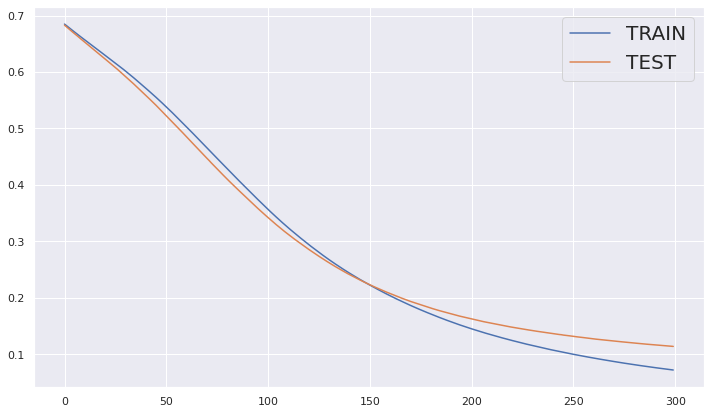

In [6]:
model = MLP(20, 10)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
check_model_quality(n_epochs=300)

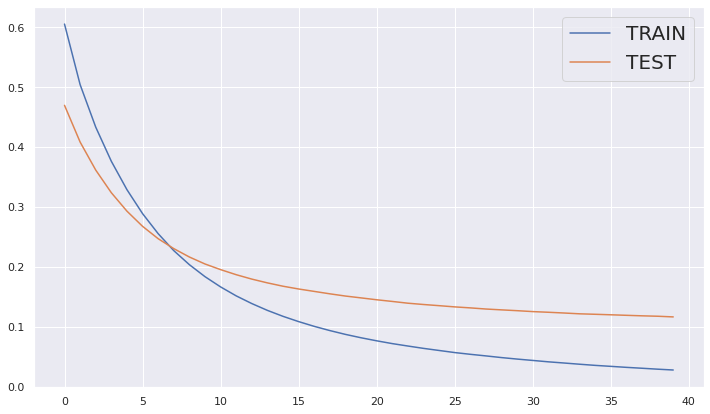

In [7]:
model = MLP(20, 10)
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)
check_model_quality(n_epochs=40)

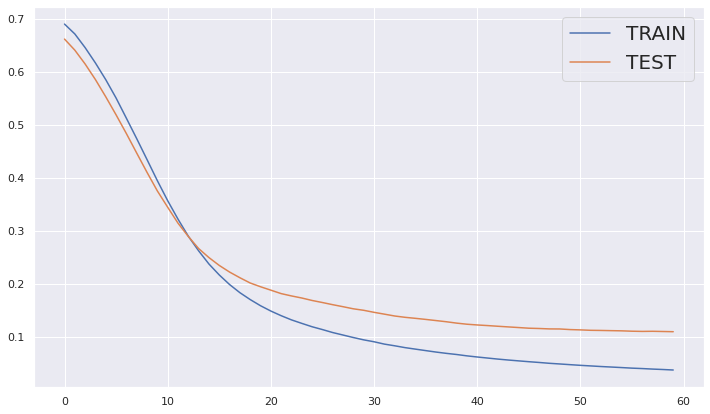

In [8]:
model = MLP(20, 10)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.95)
check_model_quality(n_epochs=60)

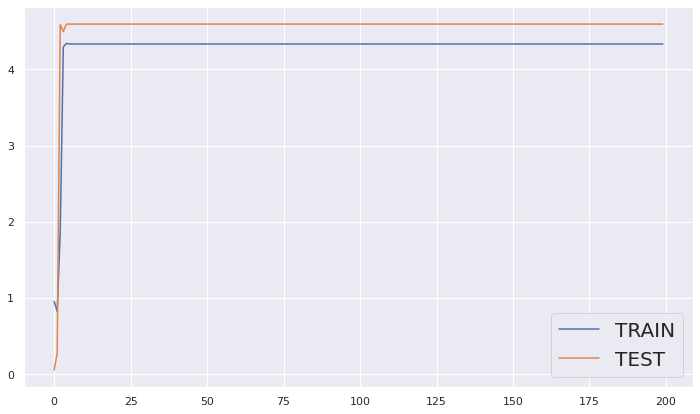

In [9]:
model = MLP(20, 10)
optimizer = optim.LBFGS(model.parameters(), lr=0.01)
check_model_quality(n_epochs=200, closure_needed=True)

**Вывод**: первые три оптимизатора в целом работают хорошо - во всех loss на тренировочной выборке стабильно падает, а вот на тестовой сначала падает, а потом остается в районе 0.1. Для L-BFGS я не справилась понять, в чем косяк и почему он вытворяет непонятно что, возможно, стоит попробовать другой loss, но те, что я пробовала, ситуацию к лучшему не поменяли :(